In [1]:
#import all the stuff
import numpy as np
from lab1_proto import *
import matplotlib.pyplot as plt
import matplotlib
from scipy.fftpack import fft
from sklearn.mixture import GaussianMixture
from lab1_tools import *
import sys
from scipy.cluster.hierarchy import dendrogram, linkage


load the data

In [2]:
example = np.load('lab1_example.npz', allow_pickle = True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle = True)['data']

(18432,)


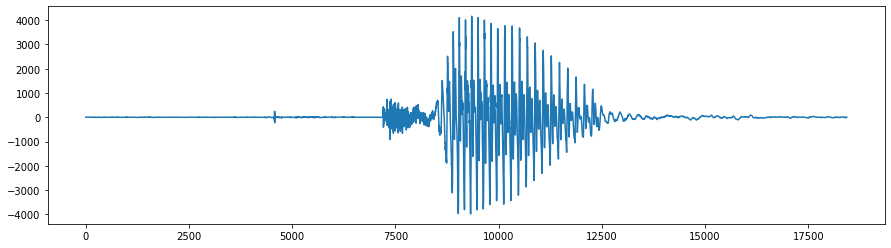

<Figure size 5760x288 with 0 Axes>

In [3]:
matplotlib.rcParams['figure.figsize'] = (15, 4)
plt.plot(example['samples'])
plt.figure(figsize=(80,4))
print(example['samples'].shape)
plt.show()

## Frame Creation

(91, 400)
(91, 400)


True

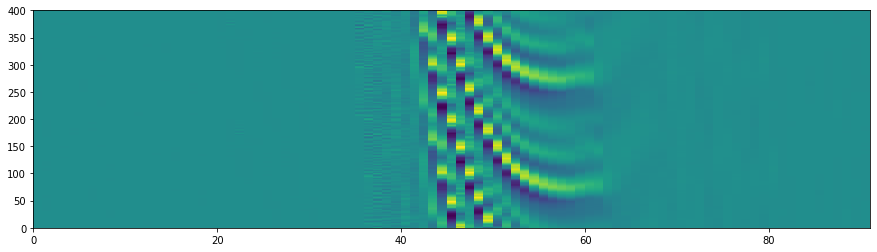

In [4]:
winlen   = 20 #ms
winshift = 10 #ms

winlenSamples   = int( example['samplingrate'] / 1000 * winlen  )
winshiftSamples = int( example['samplingrate'] / 1000 * winshift)

frames = enframe(example['samples'], winlenSamples, winshiftSamples)

print(frames.shape)
print(example['frames'].shape)
plt.pcolormesh(frames.T)

#test if close
np.isclose(frames, example['frames']).all()

## Preemphasis

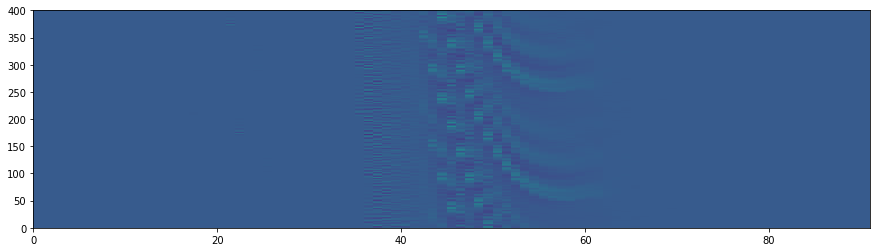

In [5]:
preempSign = preemp(frames)

np.allclose(preempSign, example['preemph'])
plt.pcolormesh(preempSign.T)
plt.show()


The filter coefficients are 
b = [1, -p] - the current one normal the last one -p
a = [1, 0]  - the output not changed, last y has no impact

## Hamming

True


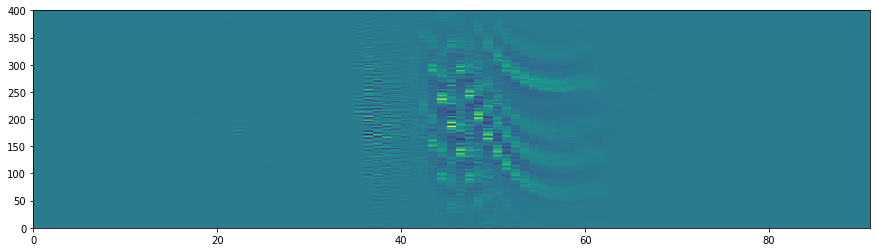

In [6]:
hamSign = windowing(preempSign)

print(np.allclose(hamSign, example['windowed']))

plt.pcolormesh(hamSign.T)
plt.show()

The hamming window is used to weight certain samples in the sampling process more than others. The middle ones should have a higher impact ones than ones about to enter or leave the window

## FFT

True


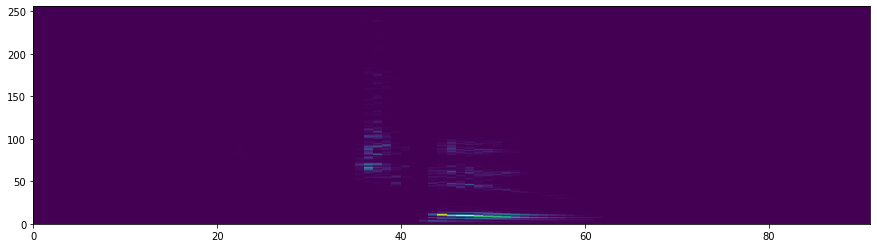

In [7]:
nfft = 512
fftSign = powerSpectrum(hamSign, nfft)

print(np.allclose(fftSign, example['spec']))

plt.pcolormesh(fftSign[:,:int(nfft/2)].T)
plt.show()

The maximum frequency we can record is given by half of the Sampling Frequency. Each index's frequency is given by the freq = index * sampling_freq/(2N)
The fft spectrum is also symmetric, tht is why we only use half of the sigal

In [8]:
print("Max freq: ", example['samplingrate']/2 /1000, "kHz")

Max freq:  10.0 kHz


## Mel Filterbank

(40, 512)


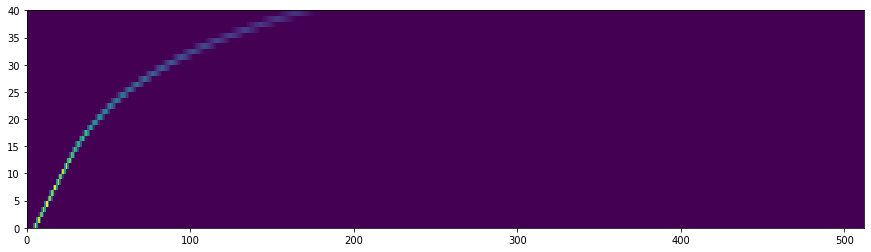

In [55]:
filterBank = trfbank(example['samplingrate'], 512)
print(filterBank.shape)
#plt.plot(filterBank)
plt.pcolormesh(filterBank)
#plt.pcolormesh(abs(fft(filterBank)))
#plt.plot(abs(fft(filterBank, 512)))
plt.show()

True


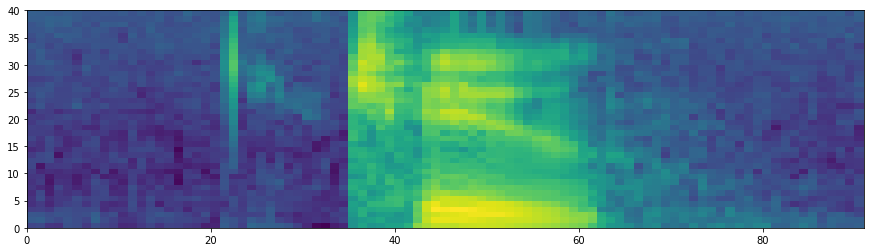

In [10]:
melSign = logMelSpectrum(fftSign, example['samplingrate'])

print(np.allclose(melSign, example['mspec']))

plt.pcolormesh(melSign.T)
plt.show()

## Cosine Transform and Liftering

(91, 13)
(91, 13)
False


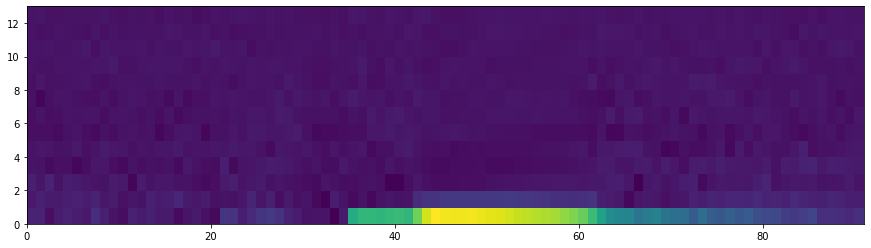

In [11]:
cosSign = cepstrum(melSign, 13)

print(cosSign.shape)
print(example['mfcc'].shape)
print(np.allclose(cosSign, example['mfcc']))

plt.pcolormesh(cosSign.T)
plt.show()

We obviously get a different result from the DCT if we call it with a different n. The definiton is as follows:
         N-1
y[k] = 2* sum x[n]*cos(pi*k*(2n+1)/(2*N)), 0 <= k < N.
          n=0

If N is only 13 the sum will be a different one and we only account for the sum will be different, than the one where n is equal to the length of the signal. Therefore taking the first 13 is different, than only generating the result with the first 13 signals

## Liftering

False


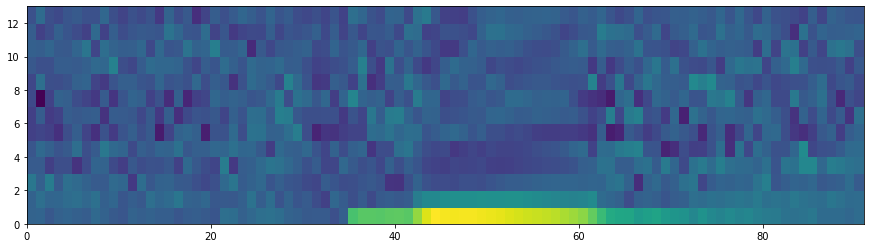

In [12]:
liftSign = lifter(cosSign)

print(np.allclose(liftSign, example['lmfcc']))

plt.pcolormesh(liftSign.T)
plt.show()

liftering to improves the relative range of Mel Frequency Cepstrum Coefficients

## Feature Correlation

giantFeatureVectore shape:  (3883, 13)
corrCoefficients (13, 13)


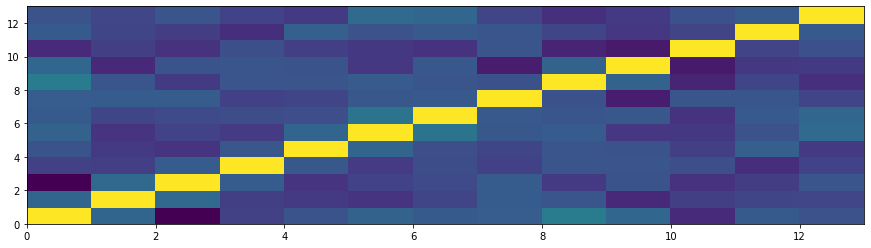

In [56]:
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']

giantFeatureVector = None
for datum in data:
    current_samples = datum['samples']
    #print(current_samples.shape)
    current_samplingrate = datum['samplingrate']
    res = mfcc(current_samples, samplingrate=current_samplingrate)
    #print(res.shape)
    if giantFeatureVector is None:
        giantFeatureVector = res
    else:
        giantFeatureVector = np.vstack((giantFeatureVector, res))
        
print("giantFeatureVectore shape: ",  giantFeatureVector.shape)
corrCoefficient = np.corrcoef(giantFeatureVector.T)

print("corrCoefficients", corrCoefficient.shape)
plt.pcolormesh(corrCoefficient)
plt.show()

giantFeatureVectore shape:  (3883, 13)


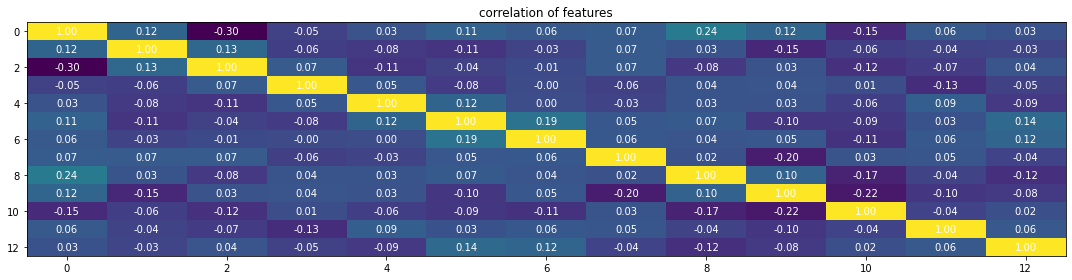

In [59]:
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']

giantFeatureVector = None
for datum in data:
    current_samples = datum['samples']
    #print(current_samples.shape)
    current_samplingrate = datum['samplingrate']
    res = mfcc(current_samples, samplingrate=current_samplingrate)
    #print(res.shape)
    if giantFeatureVector is None:
        giantFeatureVector = res
    else:
        giantFeatureVector = np.vstack((giantFeatureVector, res))
        
print("giantFeatureVectore shape: ",  giantFeatureVector.shape)
corrCoefficient = np.corrcoef(giantFeatureVector.T)


#print(corrCoefficient)
fig, ax = plt.subplots()
im = ax.imshow(corrCoefficient, interpolation='nearest', aspect='auto')
for i in range(corrCoefficient.shape[0]):
    for j in range(corrCoefficient.shape[1]):
        text = ax.text(j, i, '%.2f' % corrCoefficient[i, j],
                       ha="center", va="center", color="w")
ax.set_title("correlation of features")
fig.tight_layout()
plt.show()


As we can see the features we get from the mel frequency ceptrum coefficients, are not correlated, since all the features are getting correlation values from less then 0.3. To speak from (strong) correlation you would expect values of more than 0.5 (0.7).


### Mspec

giantFeatureVectore shape:  (3883, 40)


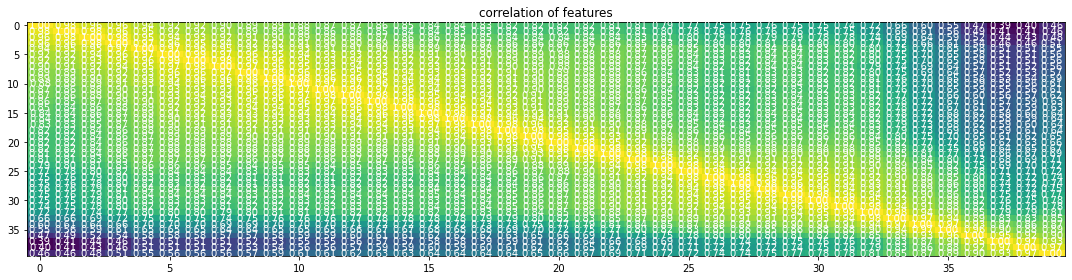

In [15]:
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']

giantFeatureVector = None
for datum in data:
    current_samples = datum['samples']
    #print(current_samples.shape)
    current_samplingrate = datum['samplingrate']
    res = mspec(current_samples, samplingrate=current_samplingrate)
    #print(res.shape)
    if giantFeatureVector is None:
        giantFeatureVector = res
    else:
        giantFeatureVector = np.vstack((giantFeatureVector, res))
        
print("giantFeatureVectore shape: ",  giantFeatureVector.shape)
corrCoefficient = np.corrcoef(giantFeatureVector.T)


#print(corrCoefficient)
fig, ax = plt.subplots()
im = ax.imshow(corrCoefficient, interpolation='nearest', aspect='auto')
for i in range(corrCoefficient.shape[0]):
    for j in range(corrCoefficient.shape[1]):
        text = ax.text(j, i, '%.2f' % corrCoefficient[i, j],
                       ha="center", va="center", color="w")
ax.set_title("correlation of features")
fig.tight_layout()
plt.show()


here we can see that many features are highly correlated giving values of more than 0.7. That is why it is good to use te mfcc instead, they give less correlation hence the dimensionality reduction is very successful. 
Is the assumption of diagonal covariance matrices for Gaussian modelling justified?
yes, since the mfcc features are not correlated the gaussian can be a diagonal matrix. Ideally the covariances between different features should be 0 if we dont have any caussality, which we can assume, because we dont see any correlation. 

## GMM

In [60]:
models = []
for num in [4,8,16,32]:
    models.append(GaussianMixture(num, covariance_type="diag"))

44


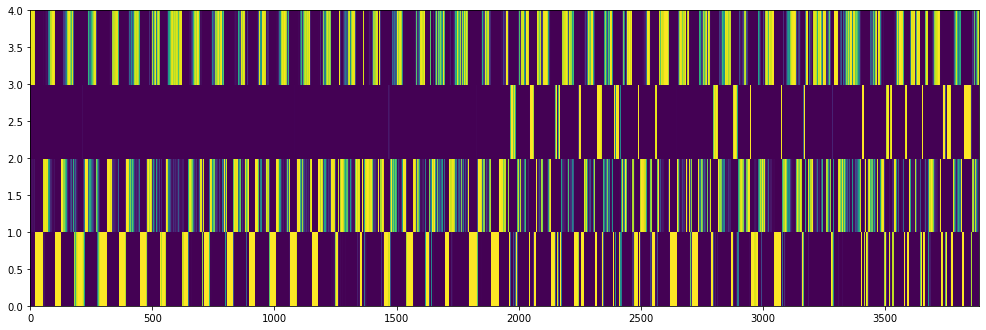

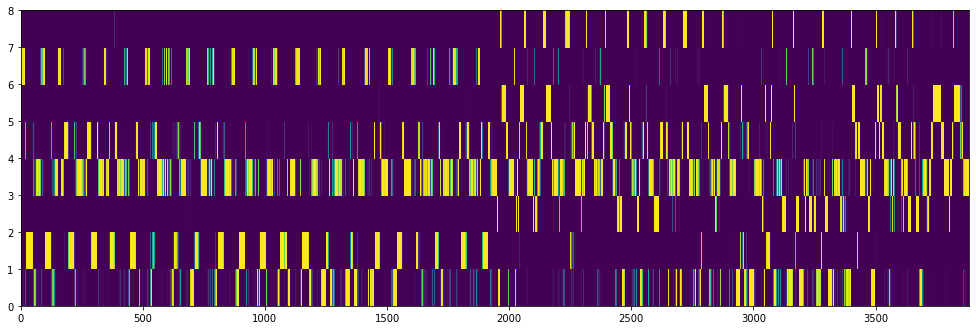

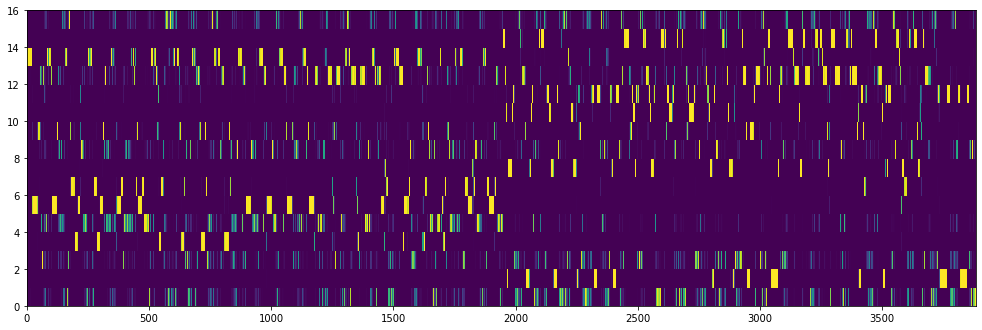

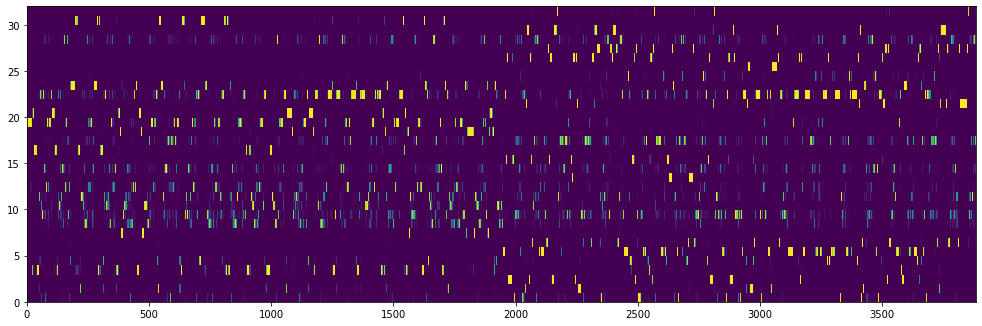

In [61]:
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']
print(len(data))

#fit the models
count = 1
for model in models:
    model.fit(giantFeatureVector)
    plt.figure(figsize=(17,25))
    plt.title('Mfcc: MFCCs model '+str(count))
    plt.subplot(len(models), 1, count)
    count += 1
    plt.pcolormesh(model.predict_proba(giantFeatureVector).T)

the gaussian mixture model tries to fit the different clusters as good as possible. Each frame will probably represent one phoneme. If we use less classes one class covers more different uttereances. ideally one frame should only have a high posterior probability for one class. The fewer classes you have the wider the variaty of different utarances in the class. 

### word seven example

44


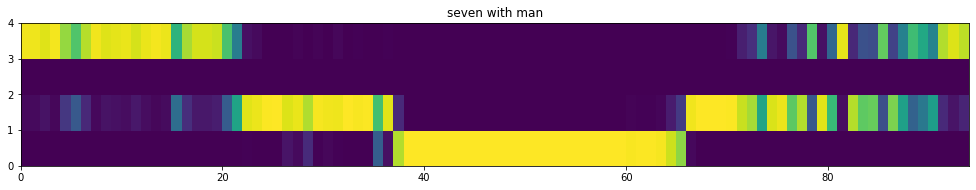

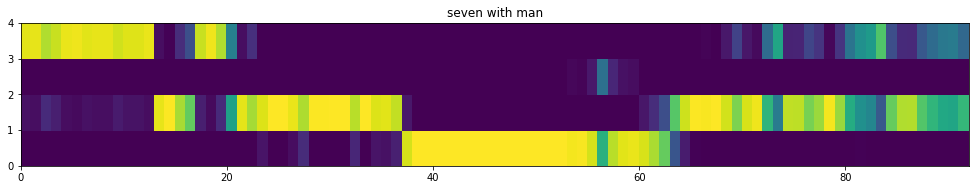

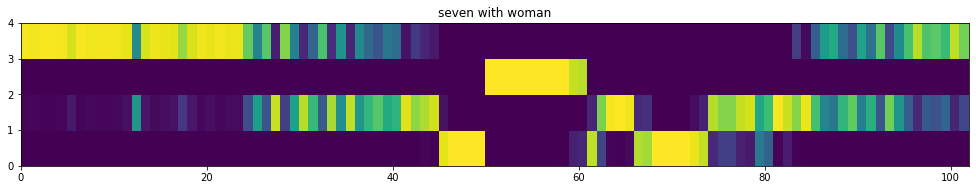

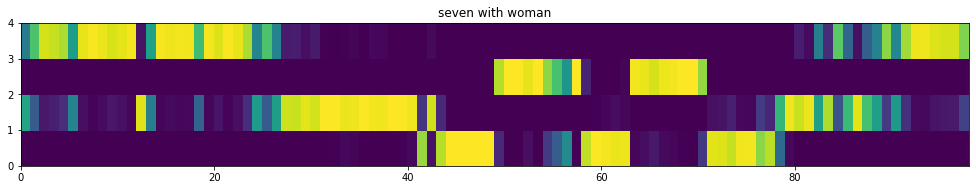

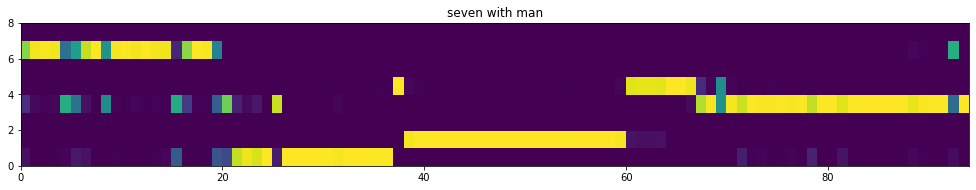

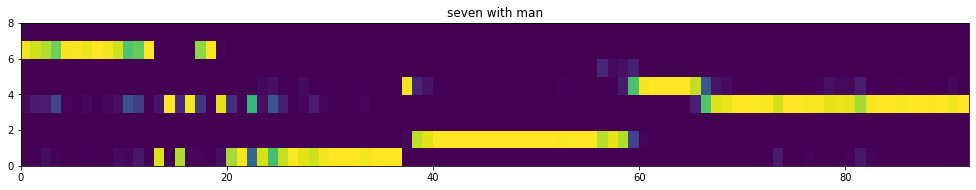

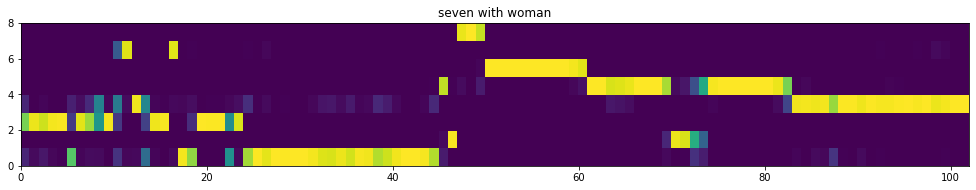

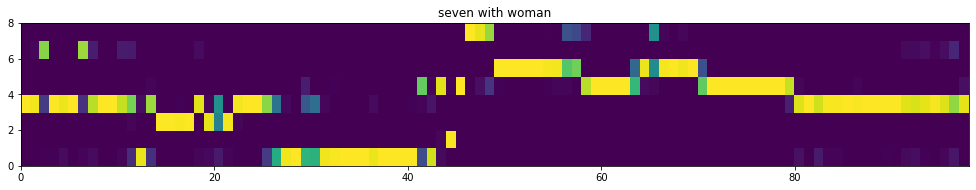

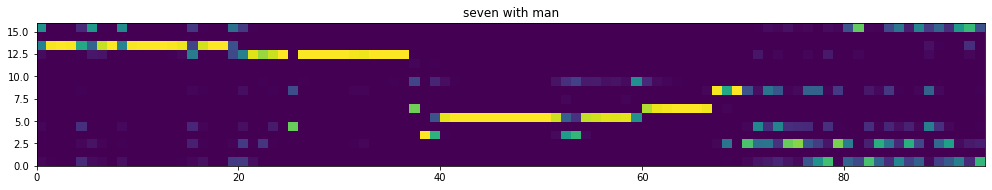

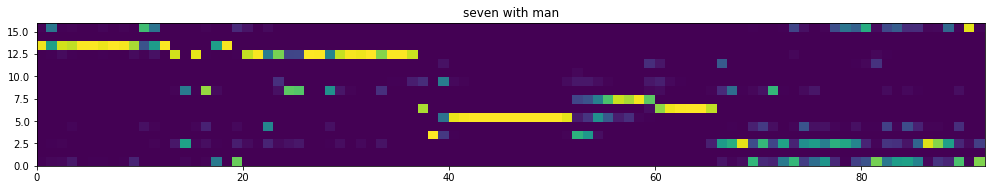

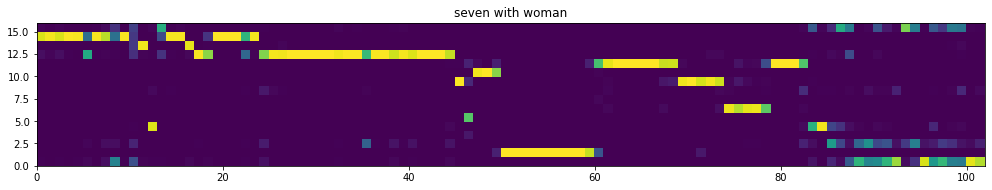

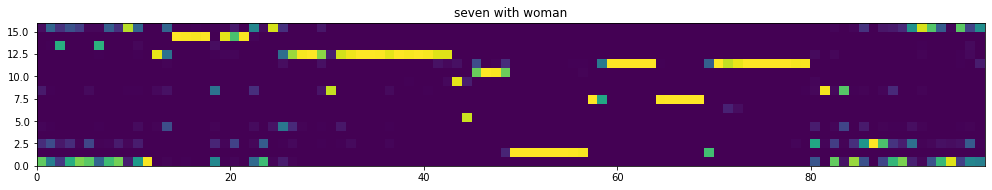

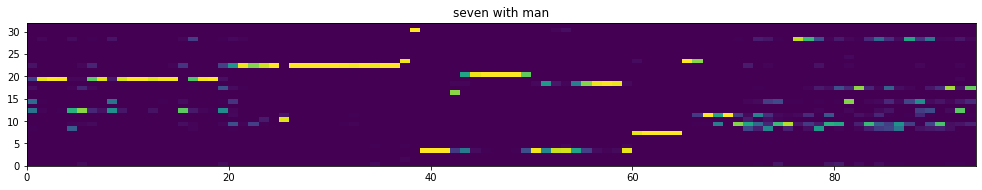

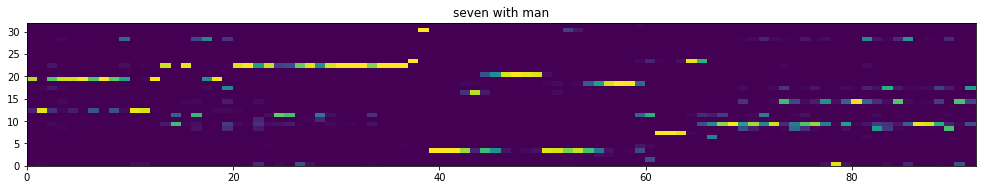

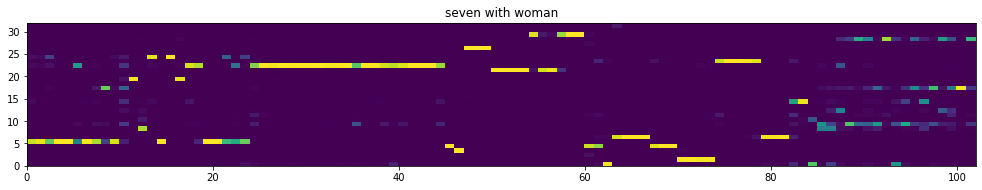

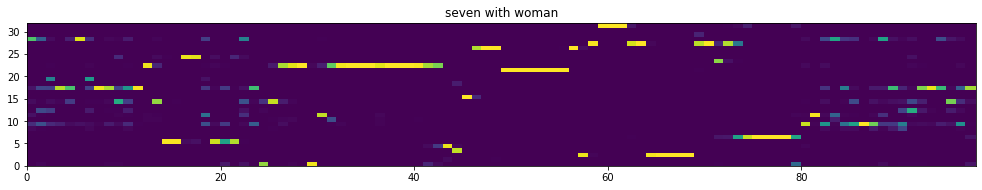

In [62]:
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']
sevens = [data[17],data[16], data[38], data[39]]
print(len(data))

count = 1
for model in models:
    for seven in sevens:
        plt.figure(figsize=(17,50))
        
        plt.subplot(len(models)*len(sevens), 1, count)
        plt.title('seven with '+seven['gender'])
        count += 1
        seven_features = model.predict_proba(mfcc(seven['samples'], samplingrate=seven['samplingrate']))
        plt.pcolormesh(seven_features.T)

Can you say something about the classes discovered by the unsupervised learning method?
if you have less classes each class is getting more frames assigned. That means it is broader. In seven you have 5 phonemes + silence - s e v e n - That means ideally 6 classes would be enough to fit the phonemes perfectly. However because we have variations and transistions between different uttarances we would maybe be able to fit a few classes more, but if we have to many classes not every class will have something relevant to fit, that is why we see almost empty classes with 16+
Do the classes roughly correspond to the phonemes you expect to compose each word?
Yes you can see a trend of 5 classes beeing mainly active, espically for the lower class fitting. And also a repetion back to the to one, which is most likely the e, which is produced twice.
Are those classes a stable representation of the word if you compare utterances from different speakers?
not really especially if you look at the difference between male and femeale pronaunication. Within gender it seems very similar, therefore it very likely a good reperesentation


# DTW

distance:  0.0


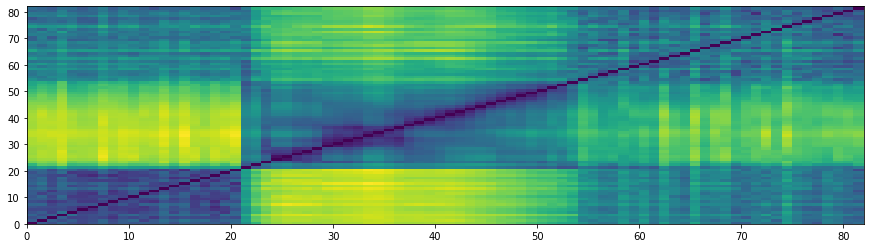

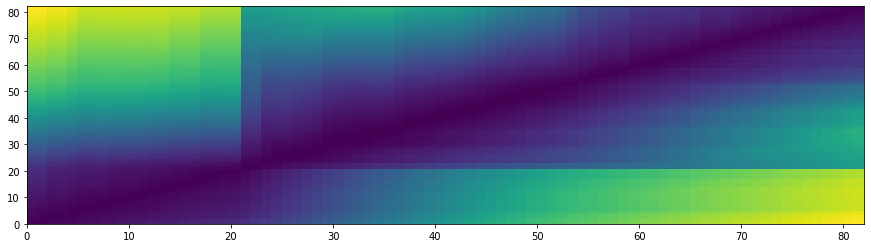

In [25]:
# check for same utterance/word
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']

feature = mfcc(data[0]['samples'], samplingrate=data[0]['samplingrate'])

d, ld, ad, path = dtw(feature, feature, "euclidean")

print("distance: ", d)
plt.pcolormesh(ld)
plt.show()
plt.pcolormesh(ad)
plt.show()

distance:  96.8672599874055


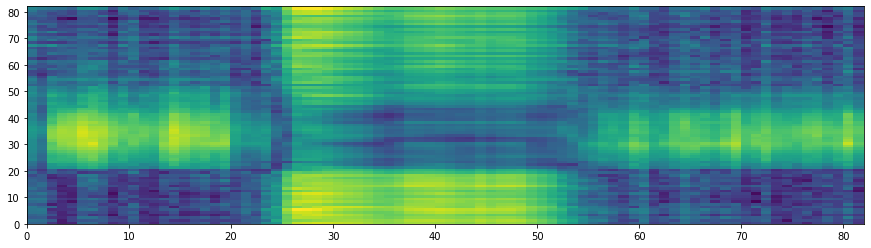

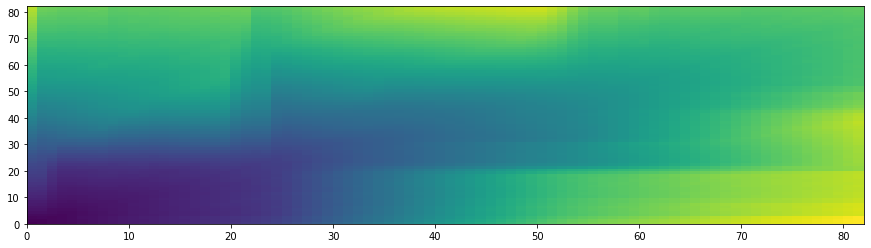

In [29]:
## different words
# check for same utterance/word
#load the data 
data = np.load('lab1_data.npz', allow_pickle=True)['data']

feature_1 = mfcc(data[4]['samples'], samplingrate=data[0]['samplingrate'])
feature_2 = mfcc(data[32]['samples'], samplingrate=data[0]['samplingrate'])
d, ld, ad, path = dtw(feature_1, feature_2, "euclidean")

print("distance: ", d)
plt.pcolormesh(ld)
plt.show()
plt.pcolormesh(ad)
plt.show()

distance:  63.60787265357612


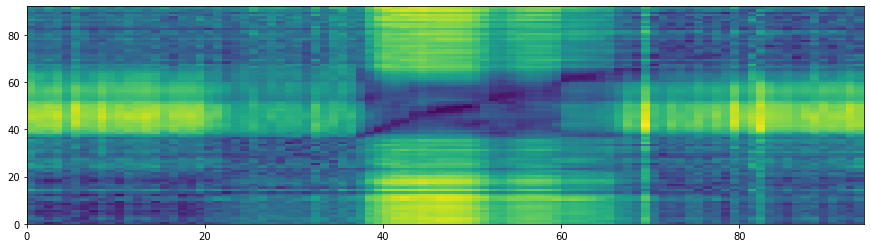

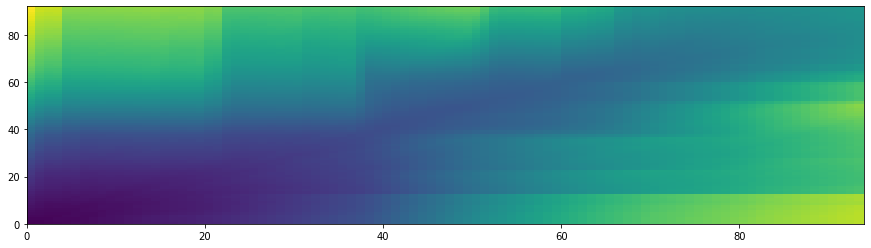

In [23]:
## two sevens male

data = np.load('lab1_data.npz', allow_pickle=True)['data']

feature_1 = mfcc(data[16]['samples'], samplingrate=data[0]['samplingrate'])
feature_2 = mfcc(data[17]['samples'], samplingrate=data[0]['samplingrate'])
d, ld, ad, path = dtw(feature_1, feature_2, "euclidean")

print("distance: ", d)
plt.pcolormesh(ld)
plt.show()
plt.pcolormesh(ad)
plt.show()

distance:  93.10322476986818


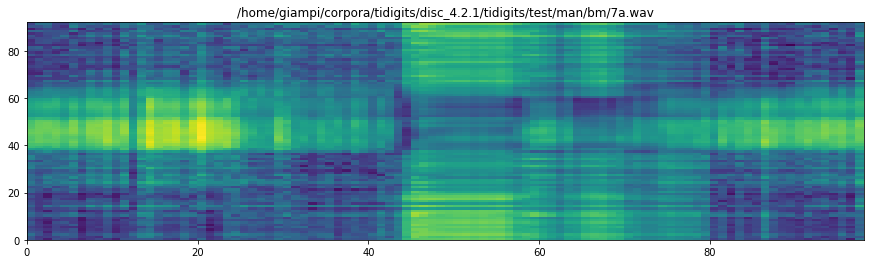

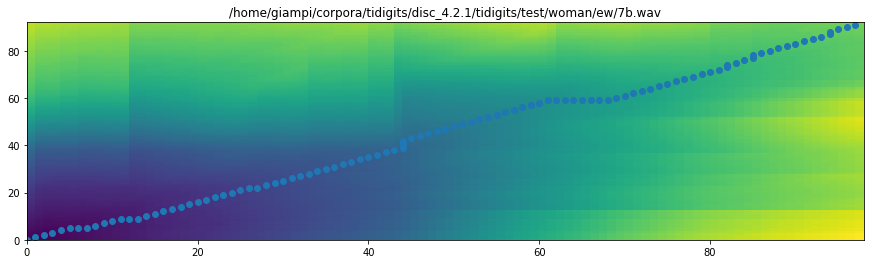

In [50]:
## seven male female

data = np.load('lab1_data.npz', allow_pickle=True)['data']
one = 16
two = 39
feature_1 = mfcc(data[one]['samples'], samplingrate=data[0]['samplingrate'])
feature_2 = mfcc(data[two]['samples'], samplingrate=data[0]['samplingrate'])
d, ld, ad, path = dtw(feature_1, feature_2, "euclidean")
path = np.array(path)
print("distance: ", d)
plt.title(data[one]['filename'])
plt.pcolormesh(ld)
plt.show()
plt.title(data[two]['filename'])
plt.pcolormesh(ad)
plt.scatter(path[:,1], path[:,0])
plt.show()

In [ ]:
## all differences

In [51]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
D = [ [dtw(mfcc(x["samples"], samplingrate=x["samplingrate"]), mfcc(y["samples"], samplingrate=y["samplingrate"]))[0] for x in data] for y in data]

44


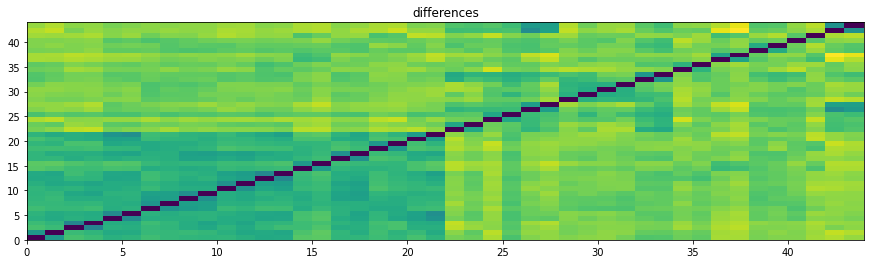

In [52]:
print(len(D))
plt.title("differences")
plt.pcolormesh(D)
plt.show()

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


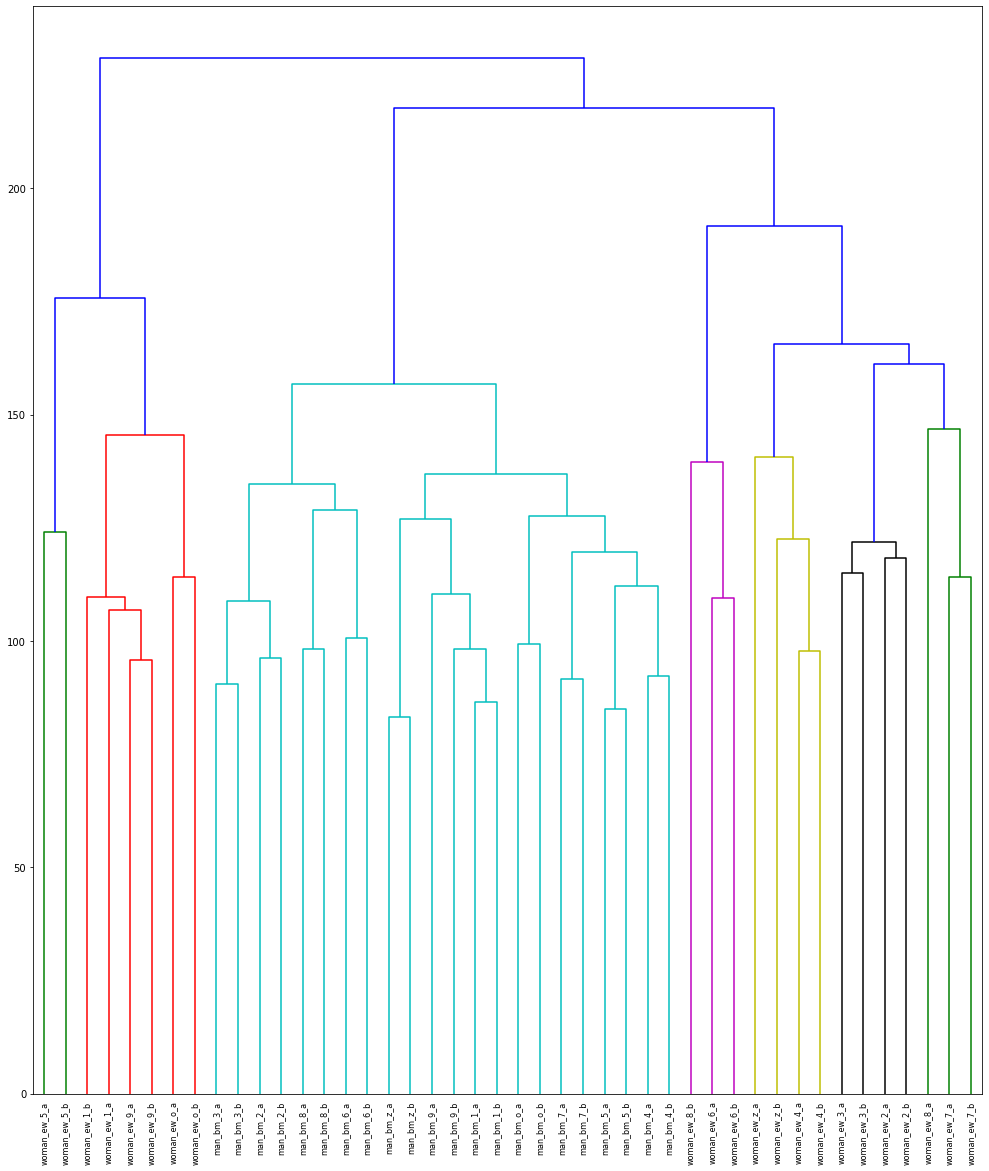

In [53]:
Z=linkage(D, method='complete')
fig = plt.figure(figsize=(17, 20))
dn = dendrogram(Z,labels=tidigit2labels(data))

Does the distance separate digits well even between different speakers?
yes we can see in the image, that only the same words have low distance, the other ones have a higher distance.
From the hierachical clustering we can see that male and female pronounciation is very different, it clusters different speach samples from the same number of the same gender rather than the same number from different genders. In general the method works qute good, we can often see, that numbers belong to the same cluster. 
It seems like for this dataset the male prononciation is more similar